# Fashionset Classification (FashionMNIST Dataset) - Refactored

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torch.autograd import Variable
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from matplotlib import pyplot as plt
from random import randint

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define a transform to normalize the data
transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

In [5]:
root_dir = 'fashion_mnist'
batch_size=64

# Download and load the training data
trainset = FashionMNIST(root=root_dir, download=True, train=True, transform=transform)
nbr_train_examples = round(len(trainset) * 0.8)
nbr_val_examples = len(trainset) - nbr_train_examples

trainset_classification, valset_classification = random_split(trainset, [nbr_train_examples, nbr_val_examples])

trainloader_classification = DataLoader(trainset_classification, batch_size=64, shuffle=True)
valloader_classification = DataLoader(valset_classification, batch_size=64, shuffle=False)

# Download and load the test data
testset = FashionMNIST(root=root_dir, download=True, train=False, transform=transform)
testset_classification = testset
testloader_classification = DataLoader(testset_classification, batch_size=batch_size, shuffle=False)

In [6]:
image, label = trainset[0]
print(image.size())
print(label)

torch.Size([1, 28, 28])
9


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
# Rotate given images by given angle

def my_segmentation_transforms(image, angle):
    image = TF.to_pil_image(image)
    image = TF.resize(image, 32, interpolation=2)
    image = TF.rotate(image, angle)
    image = TF.to_tensor(image)
    image = TF.normalize(image, (0.5, ), (0.5, ))

    return image

In [9]:
class FashionMNISTAugmentedDataset(Dataset):

    def __init__(self, data, target, transform, angle):
        self.data = data
        self.target = target
        self.transform = transform
        self.angle = angle

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):        
        datapoint = self.transform(self.data[index], self.angle)
        
        if self.angle == 0:
            target = 0 
        if self.angle == 90:
            target = 1
        if self.angle == 180:
            target = 2
        if self.angle == 270:
            target = 3
        
        return datapoint, target

In [10]:
batch_size=64

n_train = int(len(trainset) * 0.8)

train_set_0 =  FashionMNISTAugmentedDataset(
    data=trainset.data[:n_train],
    target=trainset.targets[:n_train],
    transform=my_segmentation_transforms,
    angle=0
)

train_set_90 =  FashionMNISTAugmentedDataset(
    data=trainset.data[:n_train],
    target=trainset.targets[:n_train],
    transform=my_segmentation_transforms,
    angle=90
)

train_set_180 =  FashionMNISTAugmentedDataset(
    data=trainset.data[:n_train],
    target=trainset.targets[:n_train],
    transform=my_segmentation_transforms,
    angle=180
)

train_set_270 =  FashionMNISTAugmentedDataset(
    data=trainset.data[:n_train],
    target=trainset.targets[:n_train],
    transform=my_segmentation_transforms,
    angle=270
)

val_set_0 = FashionMNISTAugmentedDataset(
    data=trainset.data[n_train:], 
    target=trainset.targets[n_train:],
    transform=my_segmentation_transforms,
    angle=0
)

val_set_90 = FashionMNISTAugmentedDataset(
    data=trainset.data[n_train:], 
    target=trainset.targets[n_train:],
    transform=my_segmentation_transforms,
    angle=90
)

val_set_180 = FashionMNISTAugmentedDataset(
    data=trainset.data[n_train:], 
    target=trainset.targets[n_train:],
    transform=my_segmentation_transforms,
    angle=180
)

val_set_270 = FashionMNISTAugmentedDataset(
    data=trainset.data[n_train:], 
    target=trainset.targets[n_train:],
    transform=my_segmentation_transforms,
    angle=270
)

test_set_0 = FashionMNISTAugmentedDataset(
    data=testset.data, 
    target=testset.targets, 
    transform=my_segmentation_transforms,
    angle=0
)

test_set_90 = FashionMNISTAugmentedDataset(
    data=testset.data, 
    target=testset.targets, 
    transform=my_segmentation_transforms,
    angle=90
)

test_set_180 = FashionMNISTAugmentedDataset(
    data=testset.data, 
    target=testset.targets, 
    transform=my_segmentation_transforms,
    angle=180
)

test_set_270 = FashionMNISTAugmentedDataset(
    data=testset.data, 
    target=testset.targets, 
    transform=my_segmentation_transforms,
    angle=270
)

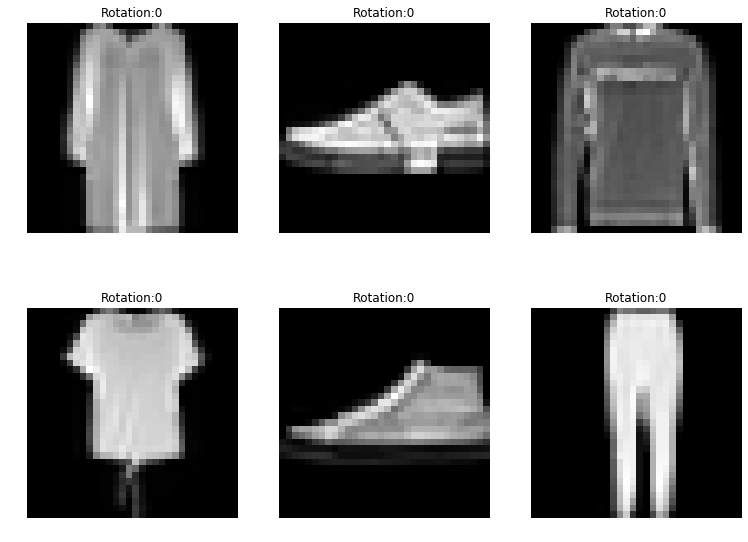

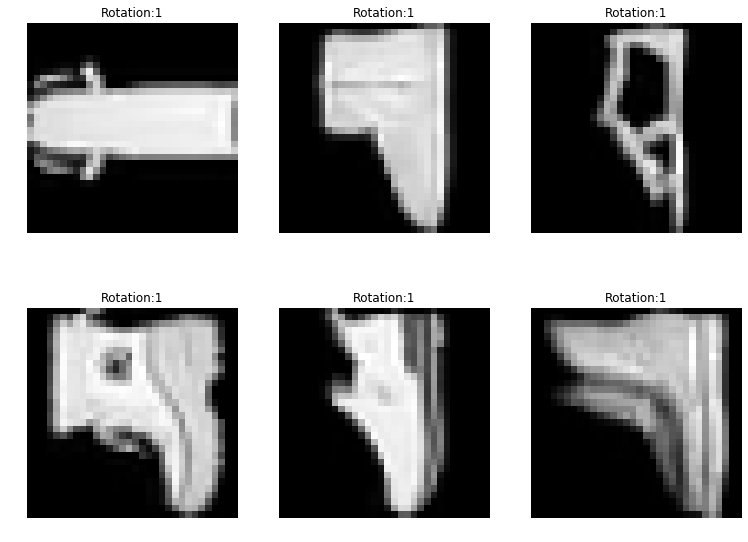

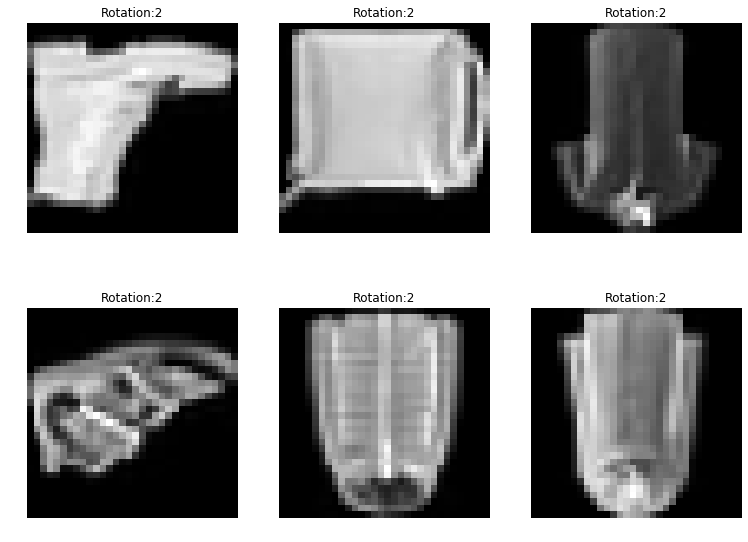

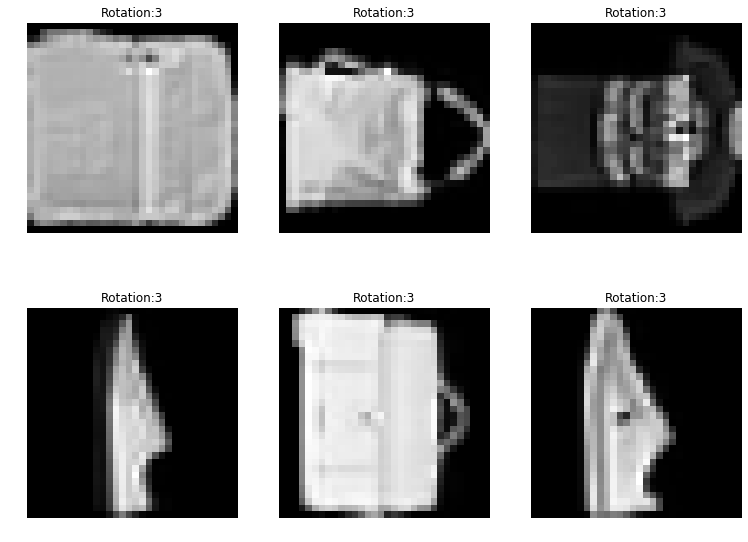

In [11]:
from matplotlib import pyplot as plt
from random import randint

datasets = [train_set_0, train_set_90, train_set_180, train_set_270]

for dataset in datasets:
    f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
    axes = [ax for axs in axes for ax in axs]

    for i in range(6):
        index = randint(0, len(dataset))
        image, label = dataset[index]
        axes[i].imshow(image[0].view(32, 32), cmap='gray')
        axes[i].set_title('Rotation:' + str(label))
        axes[i].axis('off')   

In [12]:
train_dataset = ConcatDataset([train_set_0, train_set_90, train_set_180, train_set_270])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_dataset = ConcatDataset([val_set_0, val_set_90, val_set_180, val_set_270])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

test_dataset = ConcatDataset([test_set_0, test_set_90, test_set_180, test_set_270])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [13]:
def train(model, loss_fn, optimizer, scheduler, num_epochs, trainloader, valloader):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataloader = None
    dataset_size = 0
    
    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
                dataloader = trainloader
                dataset_size = len(trainloader.dataset)
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valloader
                dataset_size = len(valloader.dataset)
             
            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            
            for data in dataloader:
                # get the inputs
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = loss_fn(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Model Building Blocks

In [14]:
def flatten(x): 
    return x.view(x.size(0), -1)

In [15]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [16]:
class BasicBlock(nn.Module):

    expansion = 1       

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(in_planes, planes, stride)
        self.conv2 = conv3x3(planes, planes)

        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

        self.stride = stride

    def forward(self, x):

        residue = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            residue = self.downsample(x)

        out += residue
        out = self.relu(out)
        return out

In [17]:
class Bottleneck(nn.Module):
    
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.downsample = downsample
        
        self.stride = stride
        
    def forward(self, x):

        residue = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(x)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            residue = self.downsample(x)

        out += residue
        out = self.relu(out)
        return out

In [18]:
class ResNet(nn.Module):

    def __init__(self, depth, name, num_classes=10, block=BasicBlock):
        super(ResNet, self).__init__()

        assert (depth - 2) % 6 == 0, 'Depth should be 6n + 2'
        n = (depth - 2) // 6

        self.name = name
        block = BasicBlock
        self.inplanes = 16
        fmaps = [16, 32, 64] # CIFAR10

        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, fmaps[0], n, stride=1)
        self.layer2 = self._make_layer(block, fmaps[1], n, stride=2)
        self.layer3 = self._make_layer(block, fmaps[2], n, stride=2)

        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.flatten = flatten
        self.fc = nn.Linear(fmaps[2] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        ''' Between layers convolve input to match dimensions -> stride = 2 '''

        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x, print_sizes=False):
        
        if print_sizes:
            print('Sizes of the tensors inside each node: \n')
            print("\t In Model: input size", x.size())
        
        x = self.relu(self.bn(self.conv(x)))    # 32x32
        
        x = self.layer1(x)                      # 32x32
        x = self.layer2(x)                      # 16x16
        x = self.layer3(x)                      # 8x8

        x = self.avgpool(x)                     # 1x1
        x = self.flatten(x)                     # Flatten
        x  = self.fc(x)                         # Dense
        
        if print_sizes:
            print("\t In Model: output size", x.size())
            
        return x

In [19]:
def ResNet20(**kwargs):    
    return ResNet(name = 'ResNet20', depth = 20, num_classes=4,**kwargs)

## Model

In [20]:
resnet20 = ResNet20()
# fitting the convolution to 1 input channel (instead of 3)
resnet20.conv = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5
resnet20_trained = train(resnet20, loss_fn, optim, sched, eps, train_loader, val_loader)

Epoch 1/5


KeyboardInterrupt: 

## Model with freezed layers + classification layer for original dataset

In [ ]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# freeze all layers of the trained model
for param in resnet20_trained.layer1.parameters():
    param.requires_grad = False
    
for param in resnet20_trained.layer2.parameters():
    param.requires_grad = False    

for param in resnet20_trained.layer3.parameters():
    param.requires_grad = False

# unfreeze final fc layer
for param in resnet20_trained.fc.parameters():
    param.requires_grad = True

# replace fc layer with 10 outputs
resnet20_trained.fc = nn.Linear(64, 10)

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20_trained.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5

resnet20_trained_classification_1 = train(resnet20_trained, loss_fn, optim, sched, eps, trainloader_classification, valloader_classification)

## Model with two freezed layers + classification layer for original dataset

In [ ]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# freeze all layers of the trained model
for param in resnet20_trained.layer1.parameters():
    param.requires_grad = False
    
for param in resnet20_trained.layer2.parameters():
    param.requires_grad = False    

for param in resnet20_trained.layer3.parameters():
    param.requires_grad = True

# unfreeze final fc layer
for param in resnet20_trained.fc.parameters():
    param.requires_grad = True

# replace fc layer with 10 outputs
resnet20_trained.fc = nn.Linear(64, 10)

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20_trained.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5

resnet20_trained_classification_2 = train(resnet20_trained, loss_fn, optim, sched, eps, trainloader_classification, valloader_classification)